In [1]:
# imports
import random 
import numpy 
import math
import pandas as pd
import matplotlib.pyplot as plt
import time
from itertools import permutations
import sys, heapq
from itertools import chain

## Part 2: Distribution Network Of Stores and Warehouses
Given 23 stores and 2 warehouses, find the best delivery route to minimize daily cost of deliveries.

Case 1: 2 Lorrys, no vans
Case 2: 1 Lorry starting at W1, trucks at W2 
Case 3: 1 Lorry starting at W2, trucks at W1
Case 4: 0 Lorrys, all trucks

Let's start by setting up the enviromnent

In [71]:
# read in the coordinates section of excel sheet
coordinates = pd.read_excel('Store-Warehouse-Data.xlsx', sheet_name='2024', usecols="A:C", nrows=25)
coordinates.rename({'Unnamed: 0': 'Labels'}, axis=1, inplace=True)
# display information that has been read in
print(coordinates)

   Labels          X          Y
0       1   6.758599  24.101122
1       2  64.202021  21.278001
2       3   3.282235  58.328059
3       4   0.356408  71.253598
4       5  47.541628  57.242195
5       6  54.139172  10.163014
6       7   5.163118  18.371369
7       8  58.107734  97.325872
8       9  22.371917  94.530747
9      10  10.921515  26.902626
10     11  40.283043  49.005961
11     12  95.906795  31.253792
12     13  38.806885  61.849634
13     14  50.773628  41.712299
14     15  16.121045   4.174152
15     16  30.572526  25.664161
16     17  88.654185  28.603406
17     18  76.158333  52.060102
18     19  57.990790  58.290169
19     20  80.118010  80.742421
20     21  99.879028  99.976906
21     22   2.587208  45.808494
22     23  74.049801   2.986131
23     W1  71.709117  17.258171
24     W2  16.606639  73.675291


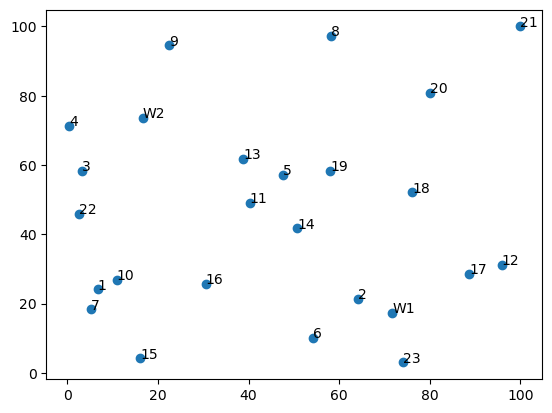

In [72]:
# plot a visual map using the coordinates
plt.scatter(coordinates["X"], coordinates["Y"])
for i in coordinates.index:
    plt.annotate(coordinates["Labels"][i], (coordinates["X"][i], coordinates["Y"][i]))
plt.show()

In [73]:
# Read in the distance matrix
distance = pd.read_excel('Part 2 Data (2024).xlsx', sheet_name='2024', usecols="B:AA", skiprows=28, nrows=25)
distance.rename({'Unnamed: 1': 'Labels'}, axis=1, inplace=True)
# Change the index to match the one in the excel sheet
distance = distance.set_index('Labels')

In [74]:
# Fill in the rest of the distance matrix
for i in distance.index:
    for j in distance.columns:
        if numpy.isnan(distance[i][j]):
            distance[i][j] = distance[j][i]
# Display the distance matrix
print(distance)


          1     2      3      4     5      6      7      8      9     10  ...  \
Labels                                                                    ...   
1         0  58.0   34.0   48.0  53.0   49.0    6.0   89.0   72.0    5.0  ...   
2        58   0.0   71.0   81.0  40.0   15.0   59.0   76.0   84.0   54.0  ...   
3        34  71.0    0.0   13.0  44.0   70.0   40.0   67.0   41.0   32.0  ...   
4        48  81.0   13.0    0.0  49.0   81.0   53.0   63.0   32.0   46.0  ...   
5        53  40.0   44.0   49.0   0.0   48.0   58.0   41.0   45.0   48.0  ...   
6        49  15.0   70.0   81.0  48.0    0.0   50.0   87.0   90.0   46.0  ...   
7         6  59.0   40.0   53.0  58.0   50.0    0.0   95.0   78.0   10.0  ...   
8        89  76.0   67.0   63.0  41.0   87.0   95.0    0.0   36.0   85.0  ...   
9        72  84.0   41.0   32.0  45.0   90.0   78.0   36.0    0.0   69.0  ...   
10        5  54.0   32.0   46.0  48.0   46.0   10.0   85.0   69.0    0.0  ...   
11       42  37.0   38.0   4

C:\Users\rodol\AppData\Local\Temp\ipykernel_5680\118299732.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distance[i][j] = distance[j][i]


In [75]:
# Convert this to a numpy matrix
distance = distance.to_numpy()
print(distance)

[[  0.  58.  34.  48.  53.  49.   6.  89.  72.   5.  42.  89.  50.  47.
   22.  24.  82.  75.  62.  93. 120.  22.  71.  65.  51.]
 [ 58.   0.  71.  81.  40.  15.  59.  76.  84.  54.  37.  33.  48.  24.
   51.  34.  26.  33.  38.  62.  86.  66.  21.   9.  71.]
 [ 34.  71.   0.  13.  44.  70.  40.  67.  41.  32.  38.  97.  36.  50.
   56.  43.  90.  73.  55.  80. 105.  13.  90.  80.  20.]
 [ 48.  81.  13.   0.  49.  81.  53.  63.  32.  46.  46. 104.  40.  58.
   69.  55.  98.  78.  59.  80. 104.  26. 100.  89.  16.]
 [ 53.  40.  44.  49.   0.  48.  58.  41.  45.  48.  11.  55.  10.  16.
   62.  36.  50.  29.  11.  40.  68.  46.  60.  47.  35.]
 [ 49.  15.  70.  81.  48.   0.  50.  87.  90.  46.  41.  47.  54.  32.
   38.  28.  39.  47.  48.  75. 101.  63.  21.  19.  74.]
 [  6.  59.  40.  53.  58.  50.   0.  95.  78.  10.  47.  92.  55.  51.
   18.  26.  84.  79.  66.  98. 125.  28.  71.  67.  56.]
 [ 89.  76.  67.  63.  41.  87.  95.   0.  36.  85.  52.  76.  40.  56.
  102.  77.  75.  

In [76]:
# Hill climb algorithm that takes in the coordinates, nodes chosen, distance matrix and number of steps
# perform hill climb for lorrys by swapping stores within itself and testing the distance generated
# keep the path with the shortest distance and repeat this process step times
# Returns the best path and it's distance
def tsphill(coords, nodes, dist, steps=1000):
    # Create initial solution
    # Gives the number of nodes
    size = len(nodes)
    # Initialize empty list to save best path
    best_path = []
    # Buids up a vector of stores/nodes passed in
    for i in range(size-1):
        best_path.append(nodes[i])
    # Randomise in between path to get initial solution
    random.shuffle(best_path)
    # Set the starting node to the last node of the passed in list aka the start warehouse
    best_path.insert(0, nodes[-1])
    # Choose based on the last node which warehouse to go
    if(dist[int(best_path[-1])-1][-1] > dist[int(best_path[-1])-1][-2]):
        best_path.append(coords["Labels"][23])
    else:
        best_path.append(coords["Labels"][24])
    # Find distance of created path
    best_distance = 0
    # add to the distance from warehouse to store 1
    best_distance = best_distance + dist[0][best_path[1]]
    # then the distances for the in between steps, from store 1 to store n-1
    for i in range(1,size-1):
        best_distance = best_distance + dist[best_path[i]-1][best_path[i+1]-1]  #Add distances of each part of the path
    #after, add the distance from the last store to the distance of the closest warehouse
    if str(best_path[-1]) == 'W1':
        best_distance = best_distance + dist[best_path[size-1]][-2]
    else:
        best_distance = best_distance + dist[best_path[size-1]][-1]
    
    # Hill-climb Algorithm
    # Number of hill-climb steps
    number_of_swaps = steps

    for x in range(number_of_swaps) :
        ##### Create a new path
        # randomly choose first and second entry to swap
        entry1 = random.randint(1,len(best_path)-2) 
        entry2 = random.randint(1,len(best_path)-2) 
        # make a new path to account for the swap
        new_path = best_path.copy()
        # swap the two chosen entries
        new_path[entry1],new_path[entry2] = new_path[entry2],new_path[entry1]
        # determine which warehouse is closer to the last store after the swap
        # then set the last warehouse to the closer one
        if(dist[new_path[-2]][-1] > dist[new_path[-2]][-2]):
            new_path[-1] = coords["Labels"][23]
        else:
            new_path[-1] = coords["Labels"][24]
        # Calculate distance of the new path
        # The first warehouse is not changed so our initial distance is 0
        new_distance = 0
        # add the distance from the starting warehouse to the first store
        new_distance = new_distance + dist[0][new_path[1]]
        # add the distances from the in between steps, from store 1 to store n-1
        for i in range(1,size-1):
            new_distance = new_distance + dist[new_path[i]-1][new_path[i+1]-1]  #Add distances of each part of the path
        # add the distance from store n-1 to the closest warehouse.
        if str(new_path[-1]) == 'W1':
            new_distance = new_distance + dist[new_path[size-1]][-2]
        else:
            new_distance = new_distance + dist[new_path[size-1]][-1]
       
        # Check if new path is shorter than best path
        # Replace best path & distance if needed
        if new_distance < best_distance:
            best_path = new_path.copy()
            best_distance = new_distance
    # Return the best path and distance
    return best_path, best_distance

In [77]:
#Situation 1a: 2 Lorry's
# Split the area in half and dedicate a zone to each warehouse
# Initialize the two zones
zone1 = []
zone2 = []
for i in coordinates.index:
    if coordinates["X"][i] > coordinates["Y"][i]:
        zone1.append(coordinates["Labels"][i])
    else:
        zone2.append(coordinates["Labels"][i])
print(zone1, zone2)
# Find shortest path starting from W1 or W2 and visiting every node

[2, 6, 12, 14, 15, 16, 17, 18, 23, 'W1'] [1, 3, 4, 5, 7, 8, 9, 10, 11, 13, 19, 20, 21, 22, 'W2']


In [78]:
# Show an example result of the algorithm on each zone
path1, distance1 = tsphill(coordinates, zone1, distance)
path2, distance2 = tsphill(coordinates, zone2, distance)
print(path1, distance1)
print(path2, distance2)

['W1', 6, 2, 23, 17, 12, 18, 14, 16, 15, 'W1'] 229.0
['W2', 9, 4, 3, 22, 1, 7, 10, 11, 13, 5, 19, 20, 21, 8, 'W2'] 296.0


[(['W1', 15, 16, 14, 18, 12, 17, 2, 6, 23, 'W1'], 202.0), (['W1', 15, 16, 14, 18, 12, 17, 2, 6, 23, 'W1'], 202.0), (['W1', 15, 16, 14, 18, 12, 17, 2, 6, 23, 'W1'], 202.0), (['W1', 15, 16, 14, 18, 12, 17, 2, 6, 23, 'W1'], 202.0), (['W1', 15, 16, 14, 18, 12, 17, 2, 6, 23, 'W1'], 202.0)]
Hill Climb gives us: 


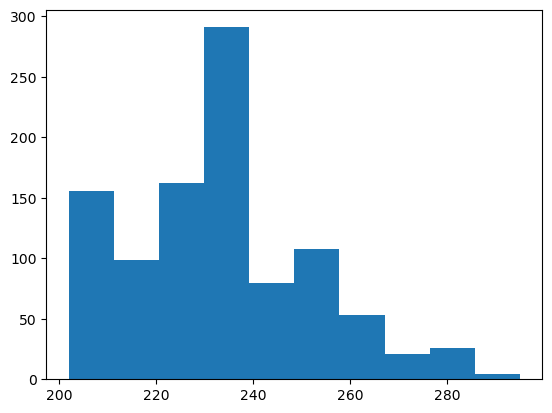

In [79]:
# perform the algorithm 1000 times with base case of 1000 steps on zone 1
# put the results of each hill climb in a list
iterations = 1000
bestlist = []
for i in range(iterations):
    temppath, tempdistance = tsphill(coordinates, zone1, distance)
    bestlist.append((temppath, tempdistance))
# from the list, take the top 5 and print them
bestlist.sort(key=lambda item: item[-1], reverse = False)
print(bestlist[0:5])
# plot the list of paths based on distance and see how consistent it is
flist = []
print("Hill Climb gives us: ")
for i in bestlist:
    flist.append(i[-1])
plt.hist(flist)
plt.show()

[(['W2', 9, 8, 21, 20, 19, 5, 11, 13, 4, 3, 22, 10, 7, 1, 'W1'], 290.0), (['W2', 9, 8, 21, 20, 19, 5, 11, 13, 4, 3, 22, 10, 7, 1, 'W1'], 290.0), (['W2', 9, 8, 21, 20, 19, 5, 11, 13, 4, 3, 22, 10, 7, 1, 'W1'], 290.0), (['W2', 9, 8, 21, 20, 19, 5, 11, 13, 4, 3, 22, 10, 7, 1, 'W1'], 290.0), (['W2', 9, 8, 21, 20, 19, 5, 11, 13, 4, 3, 22, 10, 7, 1, 'W1'], 290.0)]
Hill Climb gives us: 


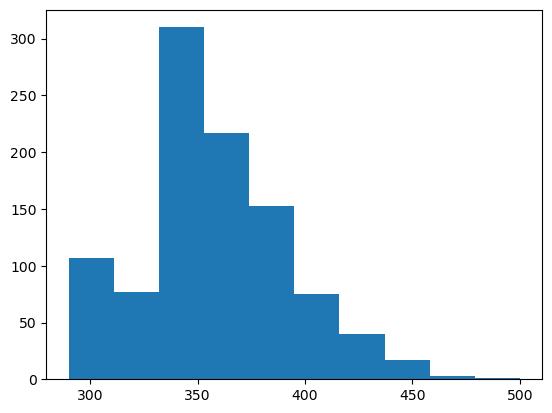

In [80]:
# perform the algorithm 1000 times with base case of 1000 steps on zone 2
# put the results of each hill climb in a list
iterations = 1000
bestlist = []
for i in range(iterations):
    temppath, tempdistance = tsphill(coordinates, zone2, distance)
    bestlist.append((temppath, tempdistance))
# from the hill climb list, take the top 5 and print them
bestlist.sort(key=lambda item: item[-1], reverse = False)
print(bestlist[0:5])
# plot the list and see how consistent it is
flist = []
print("Hill Climb gives us: ")
for i in bestlist:
    flist.append(i[-1])
plt.hist(flist)
plt.show()

### Results 1a
The best path for 2 lorry's when splitting the area in half gives us the following paths:
['W1', 15, 16, 14, 18, 12, 17, 2, 6, 23, 'W1']
['W2', 9, 8, 21, 20, 19, 5, 11, 13, 4, 3, 22, 10, 7, 1, 'W1']

With the first path costing £202 * 2 = £404
And the second path costing £290 * 2 = £580
Thus total cost is £404 + £580 = £984

In [1417]:
#Situation 1b: 2 Lorry's
# Split the amount of stores in half based on the range from the warehouses
# start with new zones to save the states
zone1 = []
zone2 = []
# make copy of distances from warehouse to each node
w1dlist = numpy.copy(distance[-2])
w2dlist = numpy.copy(distance[-1])
# check for every element in which zone it will fall into
for i in range(len(distance)):
    # find minimum distance from warehouse 1 to any point
    tempmin1 = (w1dlist.argmin()) + 1
    # replace the number logic to append the warehouse to the list
    if tempmin1 == 24:
        tempmin1 = 'W1'
    if tempmin1 == 25:
        tempmin1 = 'W2'
    # if this node has not been visited, save it to one of the zones
    if tempmin1 not in zone2 and tempmin1 not in zone1:
        zone1.append(tempmin1)
    # add back the number logic for warehouse
    if tempmin1 == 'W1':
        tempmin1 = 24
    if tempmin1 == 'W2':
        tempmin1 = 25
    # set the distance of the node to a large number s.t this number is skipped
    w1dlist[tempmin1-1] = 100000
    # do the same thing as above for the other lorry
    tempmin2 = (w2dlist.argmin()) + 1
    if tempmin2 == 24:
        tempmin2 = 'W1'
    if tempmin2 == 25:
        tempmin2 = 'W2'
    if tempmin2 not in zone1 and tempmin2 not in zone2:
        zone2.append(tempmin2)
    if tempmin2 == 'W1':
        tempmin2 = 24
    if tempmin2 == 'W2':
        tempmin2 = 25
    w2dlist[tempmin2-1] = 100000
# shift the warehouse element to last
zone1[0], zone1[-1] = zone1[-1], zone1[0]
zone2[0], zone2[-1] = zone2[-1], zone2[0]
# Display the two zones
print(zone1, zone2)

[21, 2, 23, 6, 17, 12, 14, 18, 16, 15, 20, 'W1'] [7, 4, 3, 9, 13, 22, 11, 5, 19, 10, 8, 1, 'W2']


In [1418]:
# Find shortest path starting from W1 or W2. visiting every node specified and ending at a warehouse
# Hill climb algorithm applied
path1, distance1 = tsphill(coordinates, zone1, distance)
path2, distance2 = tsphill(coordinates, zone2, distance)
print(path1, distance1)
print(path2, distance2)

['W1', 15, 16, 14, 2, 6, 23, 17, 12, 18, 20, 21, 'W2'] 290.0
['W2', 10, 7, 1, 4, 9, 8, 19, 5, 11, 13, 3, 22, 'W1'] 311.0


[(['W1', 21, 20, 18, 12, 17, 2, 14, 16, 15, 6, 23, 'W1'], 277.0), (['W1', 21, 20, 18, 12, 17, 2, 14, 16, 15, 6, 23, 'W1'], 277.0), (['W1', 21, 20, 18, 12, 17, 2, 14, 16, 15, 6, 23, 'W1'], 277.0), (['W1', 21, 20, 18, 12, 17, 2, 14, 16, 15, 6, 23, 'W1'], 277.0), (['W1', 21, 20, 18, 12, 17, 2, 14, 16, 15, 6, 23, 'W1'], 277.0)]
Hill Climb gives us: 


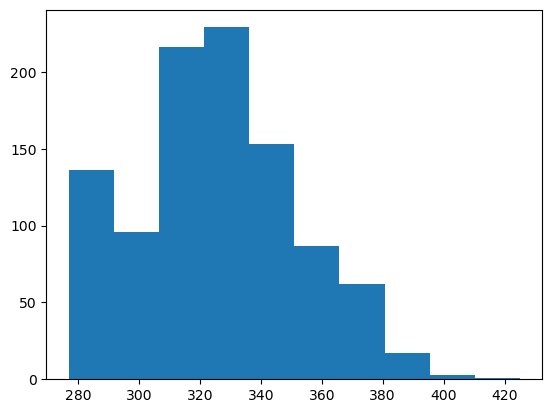

In [1419]:
# perform the algorithm 1000 times with base case of 1000 steps
# put the results of each hill climb in a list
iterations = 1000
bestlist = []
for i in range(iterations):
    temppath, tempdistance = tsphill(coordinates, zone1, distance)
    bestlist.append((temppath, tempdistance))
# from the list, take the top 5 and print them
bestlist.sort(key=lambda item: item[-1], reverse = False)
print(bestlist[0:5])
# plot the list and see how consistent it is
flist = []
print("Hill Climb gives us: ")
for i in bestlist:
    flist.append(i[-1])
plt.hist(flist)
plt.show()

[(['W2', 9, 8, 19, 5, 11, 13, 4, 3, 22, 10, 7, 1, 'W1'], 227.0), (['W2', 9, 8, 19, 5, 11, 13, 4, 3, 22, 10, 7, 1, 'W1'], 227.0), (['W2', 9, 8, 19, 5, 11, 13, 4, 3, 22, 10, 7, 1, 'W1'], 227.0), (['W2', 9, 8, 19, 5, 11, 13, 4, 3, 22, 10, 7, 1, 'W1'], 227.0), (['W2', 9, 8, 19, 5, 11, 13, 4, 3, 22, 10, 7, 1, 'W1'], 227.0)]
Hill Climb gives us: 


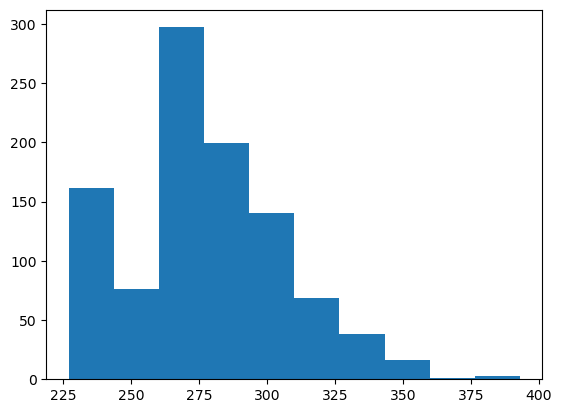

In [1420]:
# perform the algorithm 1000 times with base case of 1000 steps
# put the results of each hill climb in a list
iterations = 1000
bestlist = []
for i in range(iterations):
    temppath, tempdistance = tsphill(coordinates, zone2, distance)
    bestlist.append((temppath, tempdistance))
# from the hill climb list, take the top 5 and print them
bestlist.sort(key=lambda item: item[-1], reverse = False)
print(bestlist[0:5])
# plot the list and see how consistent it is
flist = []
print("Hill Climb gives us: ")
for i in bestlist:
    flist.append(i[-1])
plt.hist(flist)
plt.show()

### Results 1b
The best path for 2 lorry's when splitting the stores in half gives us the following paths:
['W1', 21, 20, 18, 12, 17, 2, 14, 16, 15, 6, 23, 'W1']
['W2', 9, 8, 19, 5, 11, 13, 4, 3, 22, 10, 7, 1, 'W1']

With the first path costing £277 * 2 = £554
And the second path costing £227 * 2 = £454
Thus total cost is £554 + £454 = £1008

In [1490]:
#Situation 2a: All trucks
# Split the area in half and dedicate a zone to each warehouse
# Initialize the two zones
zone1 = []
zone2 = []
for i in coordinates.index:
    if coordinates["X"][i] > coordinates["Y"][i]:
        zone1.append(coordinates["Labels"][i])
    else:
        zone2.append(coordinates["Labels"][i])
print(zone1, zone2)
# Find shortest path starting from W1 or W2 and visiting every node

[2, 6, 12, 14, 15, 16, 17, 18, 23, 'W1'] [1, 3, 4, 5, 7, 8, 9, 10, 11, 13, 19, 20, 21, 22, 'W2']


In [1618]:
#tsphill4 takes in the coordinates, the nodes, the distance and the amount of steps
# find out how many trucks are needed based on the nodes
# run the hill climb algorithm for n trucks and find the best paths one by one
# of each truck, taking into account that no store is going to be visited twice
# return n paths with their distance where n is the amount of trucks
def tsphill4(coords, nodes, dist, steps=1000):
    # Create initial solution
    # Gives the number of nodes
    size = len(nodes)
    # determine the amount of trucks needed for the nodes
    truckcount = math.ceil((size-1) / 4)
    # generate a list to hold each path with it's distance
    best_path_list = []
    # separate the store nodes from the warehouse nodes (assuming warehouse is at end of the list)
    storenodes = nodes[:-1]
    # loop for number of trucks
    for i in range(truckcount):
        # make one path at random
        best_path = []
        # take a copy of the store to swap with
        temp_nodes = storenodes.copy()
        # if the truck is not visiting max stores, take the leftover stores and
        # set them to the best path
        if len(storenodes) < 4:
            best_path = temp_nodes.copy()
        # when the leftover stores are greater than 4, make a random initial path
        # ensuring that no duplicates end up in the best path
        else:
            while(len(best_path) < 4):
                newnode = random.choice(temp_nodes)
                if newnode not in best_path:
                    best_path.append(newnode)
        # add the start warehouse node to the list
        best_path.insert(0, nodes[-1])
        # determine from the last node which warehouse will be visited last
        if(dist[int(best_path[-1])][-1] > dist[int(best_path[-1])][-2]):
            best_path.append('W1')
        else:
            best_path.append('W2')
        # find distance of this basecase path
        best_distance = 0
        # add to the distance from warehouse to store 1
        best_distance = best_distance + dist[0][best_path[1]-1]
        # then the distances for the in between steps, from store 1 to store n-1
        for i in range(1,len(best_path)-2):
            best_distance = best_distance + dist[best_path[i]-1][best_path[i+1]-1]  #Add distances of each part of the path
        #after, add the distance from the last store to the distance of the closest warehouse
        if str(best_path[-1]) == 'W1':
            best_distance = best_distance + dist[best_path[-2]][-2]
        else:
            best_distance = best_distance + dist[best_path[-2]][-1]
        # Hill-climb Algorithm
        # Number of hill-climb steps
        number_of_swaps = steps 
        # if there is a path with only one store, early return the list of best path
        # including the last truck
        if len(best_path) <= 3:
            best_path_list.append((best_path, best_distance))
            return best_path_list
        
        # iterate over number of swaps
        for x in range(number_of_swaps) :
            ##### Create a new path
            # randomly choose first entry from the path
            # and the second entry from the leftover stores to swap
            entry1 = random.randint(1,len(best_path)-2) 
            entry2 = random.randint(1,len(temp_nodes)-1) 
            # make a new path to account for the swap
            new_path = best_path.copy()
            # swap the two chosen entries
            if temp_nodes[entry2] not in new_path:
                new_path[entry1],temp_nodes[entry2] = temp_nodes[entry2],new_path[entry1]
            # determine which warehouse is closer to the last store after the swap
            # then set the last warehouse to the closer one
            if(dist[new_path[-2]][-1] > dist[new_path[-2]][-2]):
                new_path[-1] = 'W1'
            else:
                new_path[-1] = 'W2'
            # Calculate distance of the new path
            # The first warehouse is not changed so our initial distance is 0
            new_distance = 0
            # add the distance from the starting warehouse to the first store
            new_distance = new_distance + dist[0][new_path[1]]
            # add the distances from the in between steps, from store 1 to store n-1
            for i in range(1,len(new_path)-2):
                new_distance = new_distance + dist[new_path[i]-1][new_path[i+1]-1]  #Add distances of each part of the path
            # add the distance from store n-1 to the closest warehouse.
            if str(new_path[-1]) == 'W1':
                new_distance = new_distance + dist[new_path[-2]][-2]
            else:
                new_distance = new_distance + dist[new_path[-2]][-1]
       
            # Check if new path is shorter than best path
            # Replace best path & distance if needed
            if new_distance < best_distance:
                best_path = new_path.copy()
                best_distance = new_distance
                
        # add best path to a list of paths
        best_path_list.append((best_path, best_distance))
        # remove the selected node from the list
        for i in best_path[1:-1]:
            storenodes.remove(i)
    # return the list of best paths generated
    return best_path_list

In [1619]:
# show that the hill climb works for one zone
path1 = tsphill4(coordinates, zone1, distance)
print(path1)

[(['W1', 14, 23, 2, 6, 'W2'], 159.0), (['W1', 12, 18, 15, 16, 'W1'], 202.0), (['W1', 17, 'W1'], 117.0)]


In [1620]:
# show that the hill climb works for the other zone
path2 = tsphill4(coordinates, zone2, distance)
print(path2)

[(['W2', 3, 13, 5, 1, 'W1'], 156.0), (['W2', 21, 19, 11, 8, 'W2'], 175.0), (['W2', 9, 4, 22, 7, 'W2'], 139.0), (['W2', 10, 20, 'W2'], 180.0)]


In [1626]:
# perform the algorithm 1000 times with base case of 1000 steps
# put the results of each hill climb, with the total distance of the zone in a list
iterations = 10000
bestlist = []
for i in range(iterations):
    total_distance = 0
    temppath_list = tsphill4(coordinates, zone1, distance)
    # fitness determination of list of paths
    for i in temppath_list:
        total_distance += i[1]
    bestlist.append((temppath_list, total_distance))
# from the list, take the top 5 and print them
bestlist.sort(key=lambda item: item[-1], reverse = False)
print(bestlist[0])

([(['W1', 15, 6, 2, 23, 'W1'], 98.0), (['W1', 14, 18, 17, 12, 'W2'], 109.0), (['W1', 16, 'W1'], 44.0)], 251.0)


In [1627]:
# perform the algorithm 1000 times with base case of 1000 steps
# put the results of each hill climb, with the total distance of the zone in a list
iterations = 10000
bestlist = []
for i in range(iterations):
    total_distance = 0
    temppath_list = tsphill4(coordinates, zone2, distance)
    # fitness determination of list of paths
    for i in temppath_list:
        total_distance += i[1]
    bestlist.append((temppath_list, total_distance))
# from the walk list, take the top 5 and print them
bestlist.sort(key=lambda item: item[-1], reverse = False)
print(bestlist[0])

([(['W2', 21, 20, 19, 5, 'W1'], 112.0), (['W2', 9, 4, 3, 22, 'W1'], 77.0), (['W2', 1, 13, 11, 8, 'W2'], 137.0), (['W2', 7, 10, 'W2'], 50.0)], 376.0)


### Results 2a
The best path for all trucks when splitting the stores in half by area gives us the following paths:
['W1', 15, 6, 2, 23, 'W1'], ['W1', 14, 18, 17, 12, 'W2'], ['W1', 16, 'W1'], 
['W2', 21, 20, 19, 5, 'W1'], ['W2', 9, 4, 3, 22, 'W1'], ['W2', 1, 13, 11, 8, 'W2'], ['W2', 7, 10, 'W2'] 

With the first 3 paths costing £251
And the rest of the paths costing £376
Thus total cost is £251 + £376 = £627

### Results 2b
The best path for 1 lorry at warehouse 1 and 4 trucks at warehouse 2 gives us:
['W1', 15, 16, 14, 18, 12, 17, 2, 6, 23, 'W1']
['W2', 21, 20, 19, 5, 'W1'], ['W2', 9, 4, 3, 22, 'W1'], ['W2', 1, 13, 11, 8, 'W2'], ['W2', 7, 10, 'W2']
With the lorry costing £202 * 2 = £404
And the 4 trucks costing £376
Thus total cost is £404 + £376 = £780

### Result 2c
The best path for 1 lorry at warehouse 2 and 3 trucks at warehouse 1 gives us:
['W2', 9, 8, 21, 20, 19, 5, 11, 13, 4, 3, 22, 10, 7, 1, 'W1']
['W1', 15, 6, 2, 23, 'W1'], ['W1', 14, 18, 17, 12, 'W2'], ['W1', 16, 'W1']
With the lorry costing £290 * 2 = £580
And the 3 trucks costing £251
Thus total cost is £580 + £251 = £831